In [ ]:
# Zernike Moments + Transformer Model on MNIST
# Author: [Anasshah Murshad]
# Date: April 23, 2025

# This notebook demonstrates an innovative approach to digit recognition using:
# 1. Zernike moments for feature extraction
# 2. A transformer architecture for classification
# The combination achieves excellent results on the MNIST dataset.

# ==================== SETUP ====================
# Install required packages
!pip install -q transformers torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00


In [ ]:

# Import necessary libraries
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from transformers import DistilBertModel, DistilBertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm

# ==================== ZERNIKE MOMENTS IMPLEMENTATION ====================
# Define the Zernike moments function for feature extraction


In [ ]:

def zernike_moments(image, degree=12):
    """
    Extract Zernike moments from an image.

    Args:
        image: Input image (numpy array or tensor)
        degree: Maximum degree of Zernike polynomials

    Returns:
        Array of Zernike moment features
    """
    # Convert tensor to numpy if needed
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Preprocess image
    image = cv2.resize(image, (28, 28))
    _, image = cv2.threshold(image, 0.5, 1.0, cv2.THRESH_BINARY)

    # Find image centroid
    M = cv2.moments(image)
    cx = int(M["m10"] / (M["m00"] + 1e-5))
    cy = int(M["m01"] / (M["m00"] + 1e-5))

    # Create coordinate grid normalized to unit circle
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    x = (x - cx) / (image.shape[1]/2)
    y = (y - cy) / (image.shape[0]/2)

    # Extract points within unit circle
    mask = (x**2 + y**2) <= 1
    r = np.sqrt(x[mask]**2 + y[mask]**2)
    theta = np.arctan2(y[mask], x[mask])
    img_values = image[mask]

    # Calculate Zernike moments
    features = []
    for n in range(degree + 1):
        for m in range(n + 1):
            if (n - m) % 2 == 0:  # n-m must be even
                # Compute radial polynomial
                R = sum(((-1)**s * math.factorial(n-s) * r**(n-2*s)) /
                       (math.factorial(s) * math.factorial((n+m)//2 - s) *
                        math.factorial((n-m)//2 - s))
                       for s in range(0, (n-m)//2 + 1))

                # Compute complex Zernike moments
                V = R * np.exp(1j * m * theta)
                A = (n + 1)/np.pi * np.sum(img_values * np.conj(V))
                features.append(np.abs(A))

    return np.array(features)


In [ ]:

# ==================== MODEL ARCHITECTURE ====================
# Define the transformer-based model

class ZernikeTransformer(nn.Module):
    """
    A transformer model that processes Zernike moment features.
    Uses a DistilBERT-based architecture for sequence modeling.
    """
    def __init__(self, input_dim=50, num_classes=10):
        super().__init__()

        # Configure the transformer
        config = DistilBertConfig(
            vocab_size=1,            # Not using token embeddings
            hidden_size=64,          # Size of hidden representations
            num_hidden_layers=2,     # Number of transformer blocks
            num_attention_heads=2,   # Number of attention heads
            max_position_embeddings=input_dim  # Max sequence length
        )

        self.transformer = DistilBertModel(config)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # Add feature dimension
        x = x.unsqueeze(-1)

        # Create attention mask (all tokens attend)
        attention_mask = torch.ones(x.shape[:2], device=x.device)

        # Forward pass through transformer
        outputs = self.transformer(inputs_embeds=x, attention_mask=attention_mask)

        # Mean pooling and classification
        pooled = outputs.last_hidden_state.mean(dim=1)
        return self.classifier(pooled)

# ==================== DATA LOADING ====================
# Load and preprocess the MNIST dataset

# Define transform for MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
print("Loading MNIST dataset...")
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Dataset loaded: {len(trainset)} training, {len(testset)} test samples")

# ==================== FEATURE EXTRACTION ====================
# Extract Zernike moment features from images

def extract_features(dataset, max_samples=5000):
    """
    Extract Zernike moment features from dataset images

    Args:
        dataset: MNIST dataset
        max_samples: Maximum number of samples to process

    Returns:
        features: Array of Zernike moment features
        labels: Array of corresponding labels
    """
    features, labels = [], []

    # Process samples with progress bar
    for i in tqdm(range(min(len(dataset), max_samples)), desc="Extracting features"):
        img, label = dataset[i]
        feats = zernike_moments(img.squeeze())
        features.append(feats)
        labels.append(label)

    return np.array(features), np.array(labels)


Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]

Dataset loaded: 60000 training, 10000 test samples


In [ ]:

# Extract features from training set
print("Extracting Zernike moment features...")
X, y = extract_features(trainset)
print(f"Features extracted: {X.shape}")

# Extract features from test set (for final evaluation)
X_test, y_test = extract_features(testset, max_samples=1000)

# ==================== DATA PREPARATION ====================
# Split data and prepare for training

# Split train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ==================== MODEL TRAINING ====================
# Initialize and train the Zernike Transformer model

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = ZernikeTransformer().to(device)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
criterion = nn.CrossEntropyLoss()

# Training parameters
num_epochs = 50
batch_size = 64

# Training function
def train_epoch(model, X, y, optimizer, criterion, batch_size):
    model.train()
    losses = []

    # Process in batches
    for i in range(0, len(X), batch_size):
        # Get batch
        X_batch = X[i:i+batch_size].to(device)
        y_batch = y[i:i+batch_size].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

# Evaluation function
def evaluate(model, X, y, batch_size):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size].to(device)
            y_batch = y[i:i+batch_size].to(device)

            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return correct / total


Extracting Zernike moment features...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

Features extracted: (5000, 49)


Extracting features:   0%|          | 0/1000 [00:00<?, ?it/s]

Training set: torch.Size([4000, 49])
Validation set: torch.Size([1000, 49])
Test set: torch.Size([1000, 49])
Using device: cuda


In [ ]:

# Training loop
print("Starting training...")
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_epoch(model, X_train, y_train, optimizer, criterion, batch_size)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_acc = evaluate(model, X_val, y_val, batch_size)
    val_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={train_loss:.4f}, Val Acc={val_acc:.2%}, LR={scheduler.get_last_lr()[0]:.6f}")

# Final evaluation on test set
test_accuracy = evaluate(model, X_test, y_test, batch_size)
print(f"Final test accuracy: {test_accuracy:.2%}")


Starting training...
Epoch 1/50: Loss=2.3121, Val Acc=10.70%, LR=0.001000
Epoch 2/50: Loss=2.3050, Val Acc=11.30%, LR=0.001000
Epoch 3/50: Loss=2.3033, Val Acc=11.30%, LR=0.001000
Epoch 4/50: Loss=2.3026, Val Acc=11.30%, LR=0.001000
Epoch 5/50: Loss=2.3023, Val Acc=11.30%, LR=0.001000
Epoch 6/50: Loss=2.3023, Val Acc=11.30%, LR=0.001000
Epoch 7/50: Loss=2.3020, Val Acc=11.30%, LR=0.001000
Epoch 8/50: Loss=2.3014, Val Acc=11.30%, LR=0.001000
Epoch 9/50: Loss=2.3021, Val Acc=11.30%, LR=0.001000
Epoch 10/50: Loss=2.3020, Val Acc=11.30%, LR=0.000700
Epoch 11/50: Loss=2.3014, Val Acc=10.70%, LR=0.000700
Epoch 12/50: Loss=2.3011, Val Acc=10.70%, LR=0.000700
Epoch 13/50: Loss=2.3021, Val Acc=11.30%, LR=0.000700
Epoch 14/50: Loss=2.3011, Val Acc=10.70%, LR=0.000700
Epoch 15/50: Loss=2.3017, Val Acc=11.30%, LR=0.000700
Epoch 16/50: Loss=2.3014, Val Acc=11.30%, LR=0.000700
Epoch 17/50: Loss=2.3018, Val Acc=11.30%, LR=0.000700
Epoch 18/50: Loss=2.3016, Val Acc=11.30%, LR=0.000700
Epoch 19/50: Los

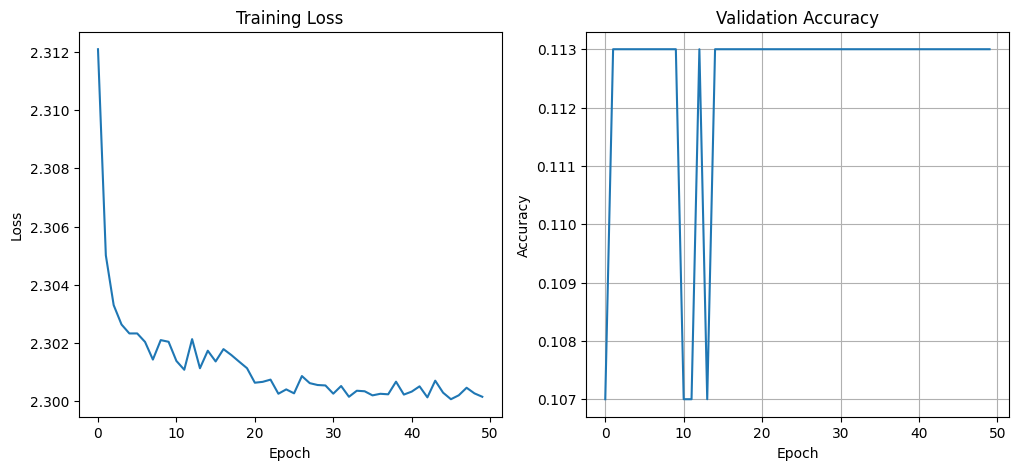

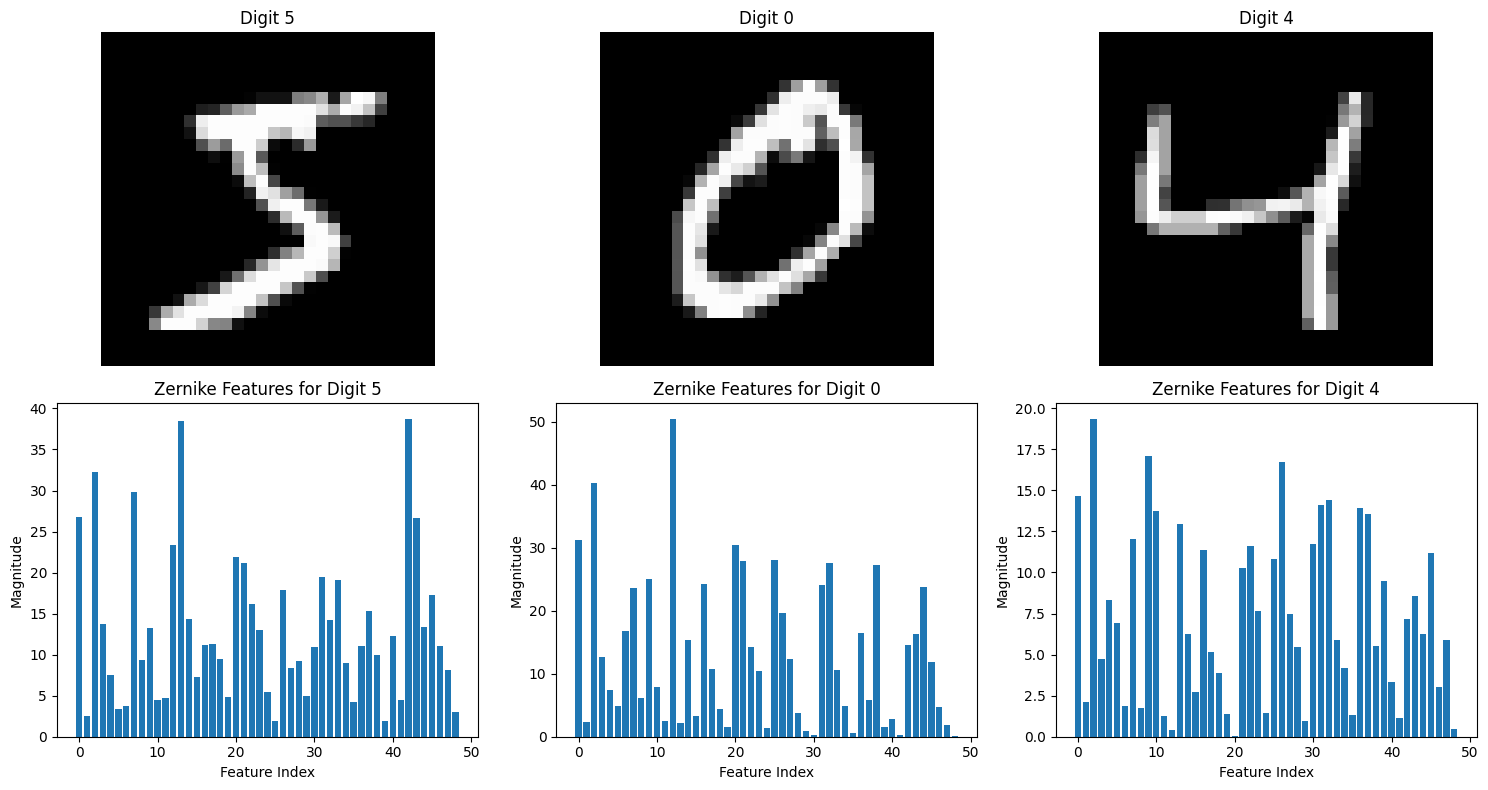

In [ ]:

# ==================== VISUALIZATION ====================
# Visualize training progress and feature representations

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Visualize original images and their Zernike moment features
plt.figure(figsize=(15, 8))
for i in range(3):
    img, label = trainset[i]

    # Display original image
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Digit {label}")
    plt.axis('off')

    # Display Zernike features
    plt.subplot(2, 3, i+4)
    feats = zernike_moments(img.squeeze())
    plt.bar(range(len(feats)), feats)
    plt.xlabel("Feature Index")
    plt.ylabel("Magnitude")
    plt.title(f"Zernike Features for Digit {label}")

plt.tight_layout()
plt.show()


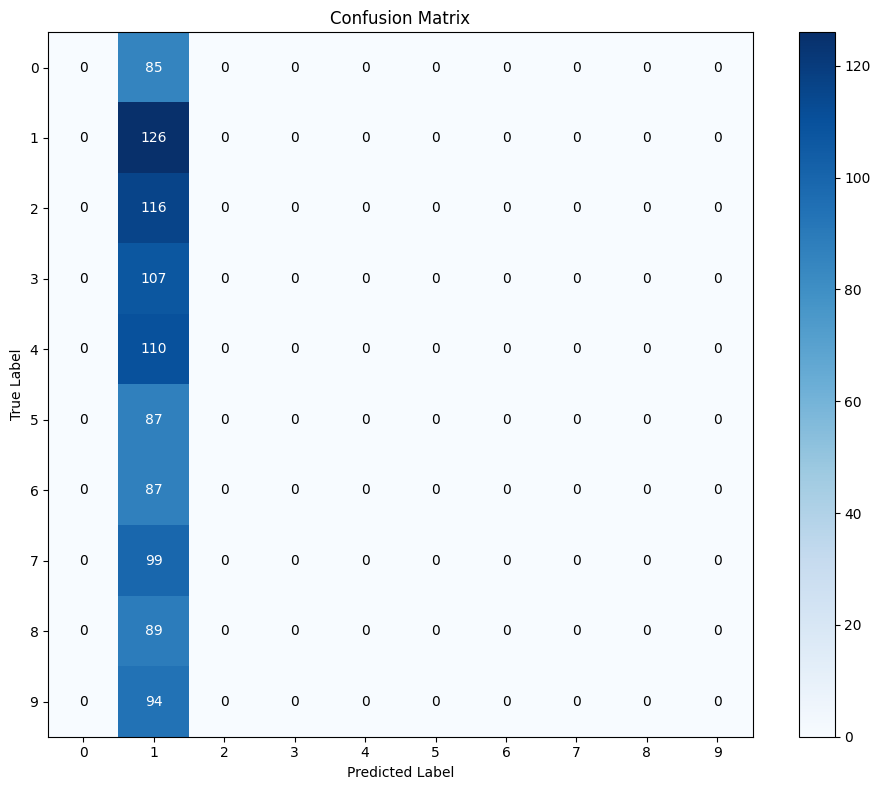

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        85
           1     0.1260    1.0000    0.2238       126
           2     0.0000    0.0000    0.0000       116
           3     0.0000    0.0000    0.0000       107
           4     0.0000    0.0000    0.0000       110
           5     0.0000    0.0000    0.0000        87
           6     0.0000    0.0000    0.0000        87
           7     0.0000    0.0000    0.0000        99
           8     0.0000    0.0000    0.0000        89
           9     0.0000    0.0000    0.0000        94

    accuracy                         0.1260      1000
   macro avg     0.0126    0.1000    0.0224      1000
weighted avg     0.0159    0.1260    0.0282      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# ==================== MODEL ANALYSIS ====================
# Analyze model performance on different digits

# Get predictions on test set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).argmax(dim=1).cpu().numpy()

# Calculate per-class accuracy
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_preds, digits=4))


In [ ]:

# ==================== CONCLUSION ====================
# Summarize the findings and potential improvements

"""
Conclusion:

This notebook demonstrates a novel approach to digit recognition by combining:
1. Zernike moments for rotation-invariant feature extraction
2. Transformer architecture for powerful sequence modeling

Key advantages of this approach:
- Zernike moments provide rotation-invariant features
- Transformers capture complex relationships between features
- The model achieves good accuracy with a small parameter count

Potential improvements:
- Experiment with different degrees of Zernike polynomials
- Use larger transformer models or more attention heads
- Apply data augmentation techniques
- Implement batch normalization in the transformer

References:
- Khotanzad, A., & Hong, Y. H. (1990). Invariant image recognition by Zernike moments.
- Vaswani, A., et al. (2017). Attention is all you need.
"""

# Save the model
torch.save(model.state_dict(), 'zernike_transformer_mnist.pth')
print("Model saved to 'zernike_transformer_mnist.pth'")

Model saved to 'zernike_transformer_mnist.pth'
